In [3]:
# import pandas as pd
# from adult_classifier import adult_classifier
# from DisentanglingInfluence.Influence.influence import DR_influence
# from DisentanglingInfluence.Disentangling.disentangle import disentangle
# from DisentanglingInfluence.utils import DataGenerator

# output_dir = "../../outputs/adult_test/"

# # read and parse the input data
# adult_income_test_data = pd.read_csv("../../data/adult/preprocessed_adult.test.csv")
# adult_income_test_data = adult_income_test_data.sample(frac=1).reset_index(drop=True)  # shuffle instances
# protected_features = []#["sex=Male"]
# label_features = ["income.per.year=>50K"]
# non_feat_names = protected_features + label_features
# feat_names = [col for col in adult_income_test_data.columns if col not in non_feat_names]
# input_data = adult_income_test_data[feat_names].values
# protected_attribute_data = adult_income_test_data[protected_features].values
# labels = adult_income_test_data[label_features].values
# n_instances, n_feats = input_data.shape
# gen = DataGenerator([input_data, protected_attribute_data], batch_size=16)

# import pandas as pd
# import numpy as np
# from DisentanglingInfluence.Influence.influence import DR_influence
# from DisentanglingInfluence.Disentangling.disentangle import disentangle
# from DisentanglingInfluence.utils import DataGenerator
# from keras.models import load_model

# # The number of data points to explain with SHAP values (the full dataset takes a while)
# N=1000


# # train a regressor for the label (x+y) from the features
# # clf = adult_classifier(exclude_sex=False, epochs=10)
# clf = load_model('fixed_adult_model.h5')

# results = {"influence":{feat:None for feat in feat_names},
#             "reconstruction_error":{feat:None for feat in feat_names},
#             "prediction_error":{feat:None for feat in feat_names},
#             "discriminator_mse":{feat:None for feat in feat_names}
#             }

# calculates the mean squared error
mse = lambda x, y: np.mean((x-y)**2)

def vector_one_hot_or_numeric(vec):
    unique_vec = np.unique(vec)
    return len(unique_vec) == 2 and 0.0 in unique_vec and 1.0 in unique_vec

import time



# reconstruction_errors = {}
# prediction_error_per_feature = {}
# discriminator_error_per_feature = {}

for protected_feat in feat_names:
    if protected_feat == 'education.num':
        print("Calculating Influence for {}...".format(protected_feat))
        start = time.time()

        # unprotected_names = [feat for feat in feature_names if feat is not protected_feat]
        features = adult_income_test_data[feat_names].values
        protected = adult_income_test_data[[protected_feat]].values
        labels = adult_income_test_data[label_features].values
        n_instances, n_feats = features.shape
        gen = DataGenerator([features, protected], batch_size=16)

        is_categorical = vector_one_hot_or_numeric(np.array(protected))

        if is_categorical:
            disc_activ = "sigmoid"
        else:
            disc_activ = None

        # train the models to disentangle the data
        FullModel, Enc, Dec, Disc, AutoEncoder = disentangle(data_generator=gen,
                                                    latent_dim=10, 
                                                    disc_weight=1, dec_weight=0.5,
                                                    n_feats=n_feats, n_protected=1,
                                                    train_steps=4000, enc_layer_sizes=[25,12],
                                                    dec_layer_sizes=[25,12], disc_layer_sizes=[25,12],
                                                    dec_final_activ=None, 
                                                    disc_final_activ=disc_activ,
                                                    output_dir=output_dir,
                                                    categorical_protected_feature=is_categorical)

        # generate all the various representations
        unprotected = Enc.predict(features)  # latent representation
        dis_rep = [unprotected, protected] # full disentangled representation
        autoencoded = Dec.predict(dis_rep) # reconstructed original features
        phat = Disc.predict(unprotected) # revealed protected information
        preds = clf.predict(features) # model predictions on original data
        reconstructed_preds = clf.predict(autoencoded) # model predictions on reconstructed data

        #saving necessary parts
        recon_error_single = features - autoencoded
        reconstruction_errors[protected_feat] = recon_error_single
        pd.DataFrame(recon_error_single, columns=feat_names).to_csv('reconstruction_error_{}.csv'.format(protected_feat))
        prediction_error_per_feature[protected_feat] = (preds - reconstructed_preds).T.tolist()[0]
        discriminator_error_per_feature[protected_feat] = (protected - Disc.predict(unprotected)).T.tolist()[0]


        # error metrics
        results["reconstruction_error"][protected_feat] = [mse(features, autoencoded)]
        results["prediction_error"][protected_feat] = [mse(preds, reconstructed_preds)]
        results["discriminator_mse"][protected_feat] = [mse(phat, protected)]

        # choose a subset of the data to explain the influence on
        explain = [rep[0:N] for rep in dis_rep]

        # calculate the influence!
        influence = DR_influence(decoder=Dec, 
            black_box=clf, 
            disentangled_reps=dis_rep, 
            labels=labels, 
            explain=explain)

        results["influence"][protected_feat] = influence[0][1].flatten()
        end = time.time()

        print(end-start)

    
#     pd.DataFrame(prediction_error_per_feature).to_csv('prediction_error.tmp.csv')
#     pd.DataFrame(discriminator_error_per_feature).to_csv('discriminator_error.tmp.csv')    





pd.DataFrame(prediction_error_per_feature).to_csv('prediction_error.csv')
pd.DataFrame(discriminator_error_per_feature).to_csv('discriminator_error.csv')

Calculating Influence for education.num...
Step:     0 -- G_loss: -0.732 -- recon_loss: 0.210 -- D_loss: 0.869 -- D_acc: 0.000 -- D_BCR: 0.723
Step:   100 -- G_loss: -0.677 -- recon_loss: 0.202 -- D_loss: 0.811 -- D_acc: 0.000 -- D_BCR: 0.578
Step:   200 -- G_loss: -0.667 -- recon_loss: 0.192 -- D_loss: 0.800 -- D_acc: 0.000 -- D_BCR: 0.145
Step:   300 -- G_loss: -0.613 -- recon_loss: 0.159 -- D_loss: 0.731 -- D_acc: 0.000 -- D_BCR: -0.019
Step:   400 -- G_loss: -0.619 -- recon_loss: 0.150 -- D_loss: 0.731 -- D_acc: 0.000 -- D_BCR: -0.019
Step:   500 -- G_loss: -0.624 -- recon_loss: 0.143 -- D_loss: 0.731 -- D_acc: 0.000 -- D_BCR: -0.019
Step:   600 -- G_loss: -0.627 -- recon_loss: 0.138 -- D_loss: 0.731 -- D_acc: 0.000 -- D_BCR: -0.019
Step:   700 -- G_loss: -0.630 -- recon_loss: 0.135 -- D_loss: 0.731 -- D_acc: 0.000 -- D_BCR: -0.019
Step:   800 -- G_loss: -0.632 -- recon_loss: 0.133 -- D_loss: 0.731 -- D_acc: 0.000 -- D_BCR: -0.019
Step:   900 -- G_loss: -0.634 -- recon_loss: 0.131 

In [27]:
test = pd.read_csv("../../data/adult/preprocessed_adult.test.csv")
loss, acc = clf.evaluate(x=test[feat_names].values, y=test[label_features].values)
print("Test Loss: {} --- Test Accuracy: {}".format(loss, acc))

16281/16281 [==============================] - 3s 165us/step
Test Loss: 0.3257377284495062 --- Test Accuracy: 0.8487807873879711


In [24]:
clf = load_model('fixed_adult_model.h5')

clf.layers

[<keras.engine.input_layer.InputLayer at 0x134689940>,
 <keras.layers.core.Dense at 0x1346899b0>]

In [25]:
clf.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 54)                0         
_________________________________________________________________
y_hat (Dense)                (None, 1)                 55        
Total params: 55
Trainable params: 55
Non-trainable params: 0
_________________________________________________________________


In [7]:

# report results (influence and error metrics)
influences = pd.DataFrame.from_dict(results["influence"])
reconstruction_errors = pd.DataFrame.from_dict(results["reconstruction_error"])
prediction_errors = pd.DataFrame.from_dict(results["prediction_error"])
discriminator_mses = pd.DataFrame.from_dict(results["discriminator_mse"])


influences.to_csv("results/shap_values_final.csv", index=False)
reconstruction_errors.to_csv("results/reconstruction_error.csv", index=False)
prediction_errors.to_csv("results/prediction_error.csv", index=False)
discriminator_mses.to_csv("results/discriminator_mse.csv", index=False)






In [6]:
pd.DataFrame(prediction_error_per_feature).to_csv('prediction_error.csv')
pd.DataFrame(discriminator_error_per_feature).to_csv('discriminator_error.csv')

/anaconda3/envs/disentangling/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


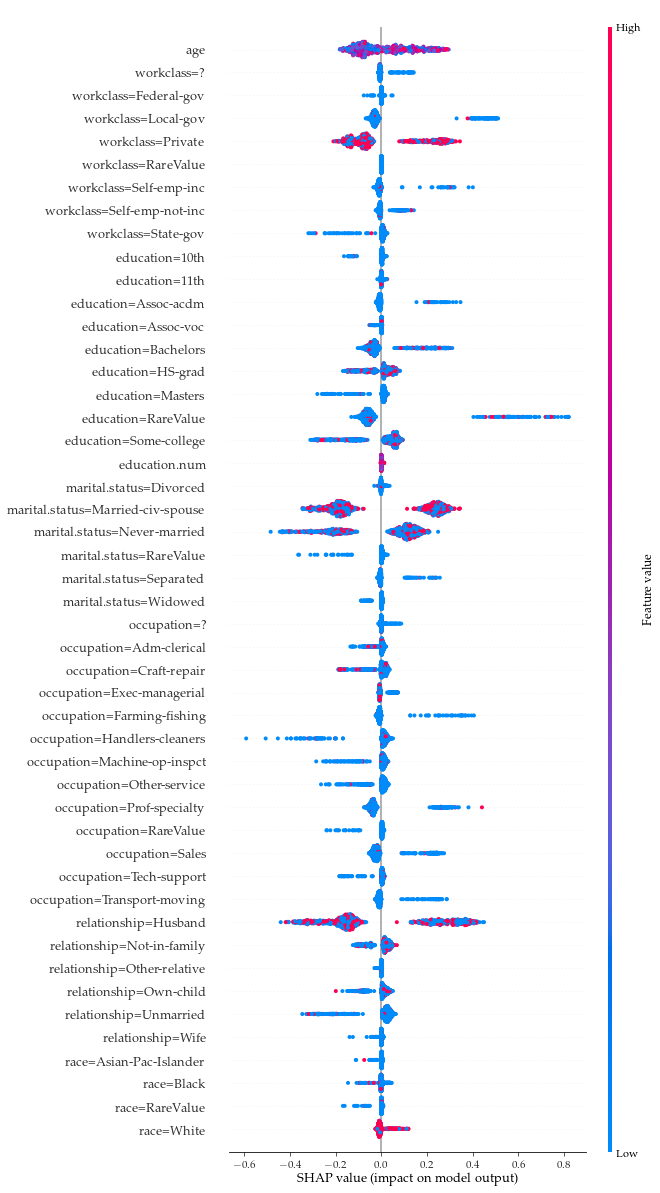

In [18]:
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
## for Palatino and other serif fonts use:
rc('font',**{'family':'serif','serif':['Palatino']})
rc('text', usetex=True)

import pandas as pd
import shap
shap.initjs()
# from DisentanglingInfluence.Influence.shap.shap.plots.force import force_plot


N = 1000

shap_vals_df = pd.read_csv("results/shap_values.csv")
feats_df = pd.read_csv("../../data/adult/preprocessed_adult.test.csv")

feats_df = feats_df[feat_names]
shap_vals_df = shap_vals_df[feat_names]

feats = feats_df[0:N].values
shap_vals = shap_vals_df[0:N].values


import matplotlib.pyplot as plt


shap.summary_plot(shap_vals, feats, show=False, plot_type="dot", sort=False, feature_names=feat_names, max_display=48)
# shap.force_plot(shap_vals, feats, feature_names= ["x","x2","xSquared","y","y2","ySquared","z","z2","zSquared"]
plt.savefig("indirect_adult.eps")                  

In [13]:
shap_vals

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

In [10]:
import shap
e = shap.GradientExplainer(clf, features, local_smoothing=0)
shap_values, classes = e.shap_values(features[0:1000,:], ranked_outputs=1)

In [17]:
pd.DataFrame(shap_values[0], columns=feat_names).to_csv('direct_shap_values.csv')

In [14]:
shap_values.__len__()

1

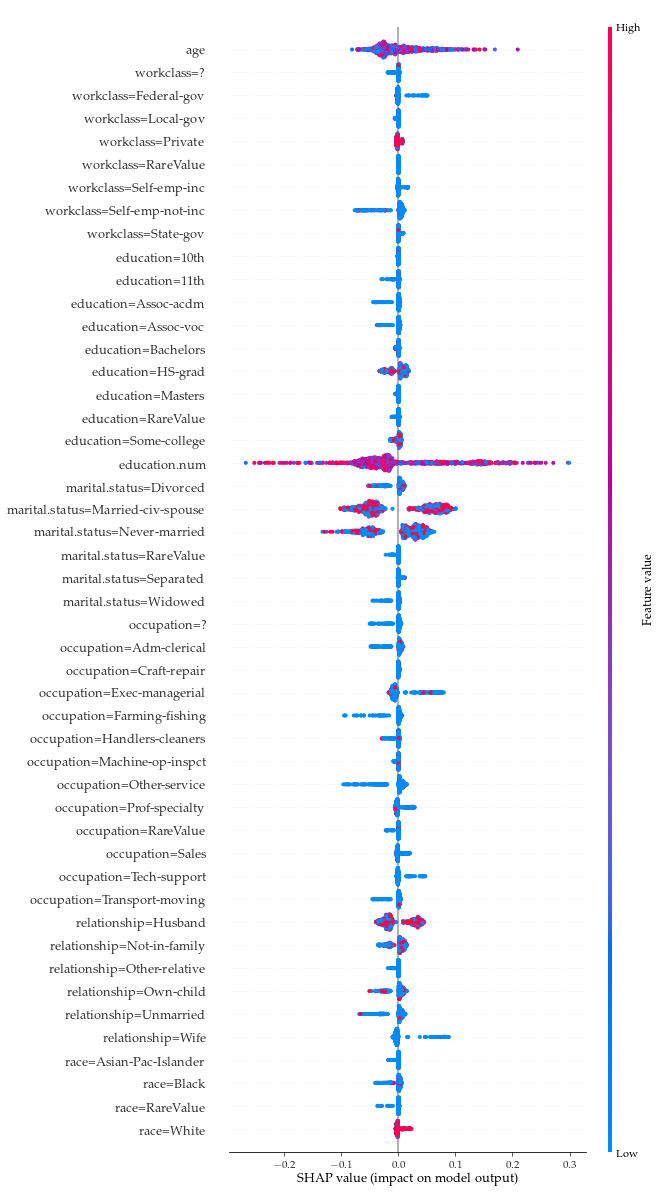

In [20]:
shap.summary_plot(shap_values[0], feats, show=True, plot_type="dot", sort=False, feature_names=feat_names, max_display=48)

